In [18]:
import json
import os
import pickle
from abc import abstractmethod

import librosa as librosa
import pandas as pd
import torch
from enum import Enum
import typing as tp
from dataclasses import dataclass
import numpy as np
import torchaudio
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import sklearn
from torch.nn.functional import cross_entropy
from sklearn.model_selection import train_test_split
from ex2.Ex2.genre_classifier import Genre
import json
import pandas as pd
import librosa
from multiprocessing import Pool
import matplotlib.pyplot as plt



In [2]:
def load_wav_files(json_file_path):
    # Read the JSON file
    with open(json_file_path) as json_file:
        data = json.load(json_file)

    # Create an empty DataFrame
    df = pd.DataFrame(columns=['label', 'audio', 'sr'])

    # Iterate over first 50 items in the JSON data
    for item in data:
        path = item['path']
        label = item['label']
        label = str.replace(label, '-', '_')
        label = Genre[label.upper()].value
        # Load the audio file using librosa
        audio, sr = librosa.load(path, sr=None)

        # Append the path, label, and audio to the DataFrameu78yt6r5fe4
        df = df.append({'label': label, 'audio': audio, 'sr': sr}, ignore_index=True)

    df = df.sample(frac=1).reset_index(drop=True)
    return df

In [3]:
# load both train and test data, then combine them
train_df = load_wav_files('jsons/train.json')
test_df = load_wav_files('jsons/test.json')
df = pd.concat([train_df, test_df], ignore_index=True)

In [9]:
data = np.asarray(df['audio'].tolist())
labels = np.asarray(df['label'].tolist())
data.shape

(1198, 266112)

# extract features not efficient but works

In [15]:
import librosa
import numpy as np
import scipy.stats

def extract_advanced_features(wavs):
    all_features = []

    for wav in wavs:
        print("start wav")
        # Calculate MFCC
        mfccs = librosa.feature.mfcc(y=wav, sr=22050, n_mfcc=40)

        # Calculate spectral contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=wav, sr=22050)

        # Calculate chroma features
        chroma_stft = librosa.feature.chroma_stft(y=wav, sr=22050)

        # Calculate tonnetz
        tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(wav), sr=22050)

        # Calculate spectral bandwidth
        spec_bw = librosa.feature.spectral_bandwidth(y=wav, sr=22050)

        # Calculate spectral flatness
        spec_flatness = librosa.feature.spectral_flatness(y=wav)

        # Calculate zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(wav)

        # Calculate RMS
        rms = librosa.feature.rms(y=wav)

        # Calculate spectral rolloff
        rolloff = librosa.feature.spectral_rolloff(y=wav, sr=22050)

        # Stack all features
        features = np.vstack([mfccs, spectral_contrast, chroma_stft, tonnetz, spec_bw, spec_flatness, zcr, rms, rolloff])

        # Calculate various statistics for each feature
        feature_stats = np.hstack([np.mean(features, axis=1),
                                   np.std(features, axis=1),
                                   np.median(features, axis=1),
                                   np.min(features, axis=1),
                                   np.max(features, axis=1),
                                   scipy.stats.skew(features, axis=1)])

        all_features.append(feature_stats)

    return np.array(all_features)

In [17]:
features = extract_advanced_features(data[0:200, :])

start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav
start wav


In [22]:
class LogisticRegressor:
    def __init__(self, input_dim: int, num_classes: int):
        self.weights = torch.randn(input_dim, num_classes, requires_grad=True)
        self.bias = torch.randn(num_classes, requires_grad=True)

    def forward(self, feats: torch.Tensor) -> torch.Tensor:
        return torch.mm(feats, self.weights) + self.bias

    def backward(self, feats: torch.Tensor, output_scores: torch.Tensor, labels: torch.Tensor):
        loss = torch.nn.functional.cross_entropy(output_scores, labels)
        loss.backward()

        with torch.no_grad():
            self.weights -= 0.01 * self.weights.grad
            self.bias -= 0.01 * self.bias.grad

            # zero the gradients after updating
            self.weights.grad.zero_()
            self.bias.grad.zero_()

    def extract_feats(self, wavs: torch.Tensor):
        # insert your feature extraction logic here
        pass


from sklearn.model_selection import train_test_split
import torch


def train_and_test_model(features: np.ndarray, labels: np.ndarray, epochs = 100):
    # convert features and labels to torch tensors
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.long)

    # split the features and labels into a training set and a testing set
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # get the number of features from the feature data
    input_dim = X_train.shape[1]

    # get the number of unique classes from the labels
    num_classes = len(torch.unique(labels))

    # create the model
    model = LogisticRegressor(input_dim, num_classes)

    # training loop
    print(epochs)
    for epoch in range(epochs):
        # forward pass
        output_scores = model.forward(X_train)

        # backward pass and optimization
        model.backward(X_train, output_scores, y_train)

        # print loss every 10 epochs
        if (epoch + 1) % 10 == 0:
            loss = torch.nn.functional.cross_entropy(output_scores, y_train)
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')

    # testing the model
    test_output_scores = model.forward(X_test)
    _, predicted = torch.max(test_output_scores.data, 1)
    correct = (predicted == y_test).sum().item()
    test_accuracy = correct / len(y_test)
    print(f'Test accuracy: {test_accuracy * 100:.2f}%')

    return model

In [42]:
def visualize_model_features(model):
    weights = model.weights.detach().numpy()

    # Average weights across output classes
    average_weights = abs(np.mean(weights, axis=1))

    plt.figure(figsize=(10, 6))
    # plot a bar plot, but group the x axis by feature type (6 consecutive features), and stack the bars by output class
    plt.bar(np.arange(len(average_weights)), average_weights)
    plt.xticks(np.arange(0, len(average_weights), 6) + 2.5,
               ['mfccs', 'spectral_contrast', 'chroma_stft', 'tonnetz', 'spec_bw', 'spec_flatness', 'zcr', 'rms', 'rolloff'])
    plt.xlabel('Feature type')
    plt.ylabel('Weight')
    plt.legend()
    plt.show()

100
Epoch 10/100, Loss: 139850.125
Epoch 20/100, Loss: 45298.21875
Epoch 30/100, Loss: 40720.21484375
Epoch 40/100, Loss: 23130.275390625
Epoch 50/100, Loss: 74542.046875
Epoch 60/100, Loss: 117213.25
Epoch 70/100, Loss: 11498.9755859375
Epoch 80/100, Loss: 9458.185546875
Epoch 90/100, Loss: 9393.9697265625
Epoch 100/100, Loss: 74328.2109375
Test accuracy: 65.00%


ValueError: The number of FixedLocator locations (70), usually from a call to set_ticks, does not match the number of ticklabels (9).

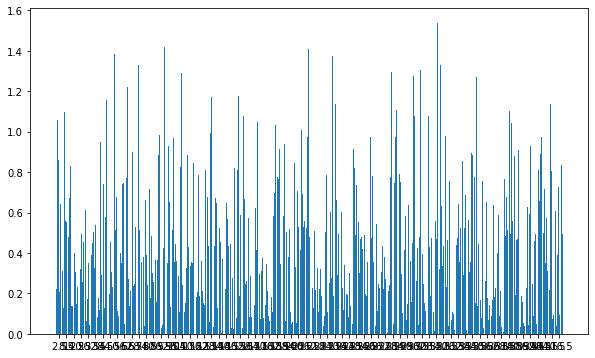

In [46]:
model = train_and_test_model(features, labels[:200], epochs=100)
visualize_model_features(model)
